In [5]:
TRAIN_TFRECORD = 'data/train.tfrecord'
TRAIN_TFRECORD_FILEPATTERN = TRAIN_TFRECORD + '*'
SAVE_DIR = 'models/ddsp-vocal-decoder'

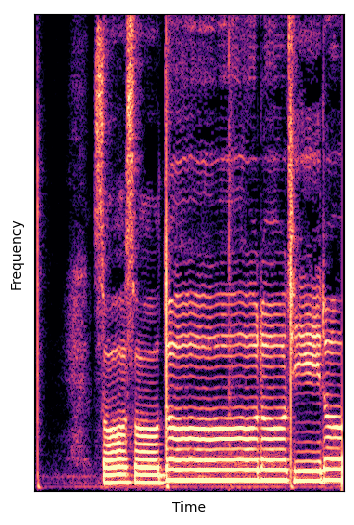

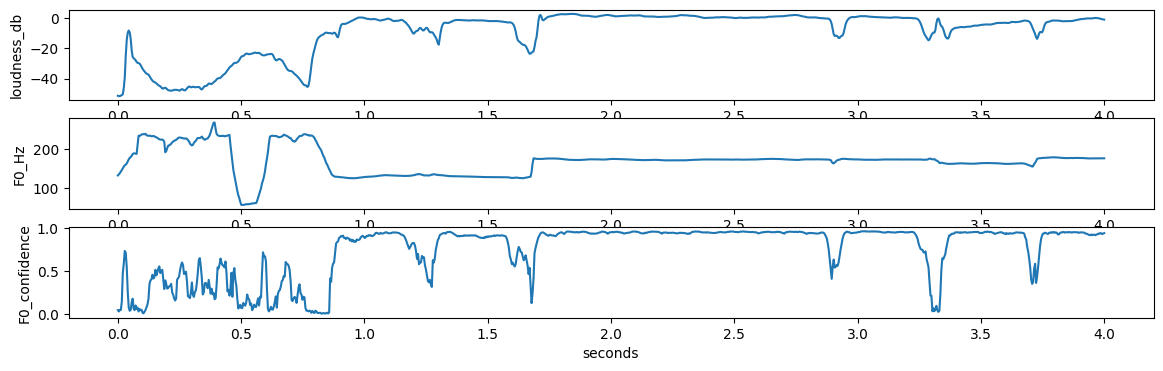

In [6]:
#from ddsp.colab import colab_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np
from misc_util import util

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

util.specplot(ex['audio'])
util.play(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])

In [8]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

Reusing TensorBoard on port 6006 (pid 33756), started 0:00:07 ago. (Use '!kill 33756' to kill it.)

In [9]:
#FIXME: figure out how to include z-decoder
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/vocal_decoder.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='data/train.tfrecord*'" \ 
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"

I1129 17:50:43.381152 32136 ddsp_run.py:179] Restore Dir: models/ddsp-vocal-decoder
I1129 17:50:43.381152 32136 ddsp_run.py:180] Save Dir: models/ddsp-vocal-decoder
I1129 17:50:43.382152 32136 resource_reader.py:50] system_path_file_exists:optimization\base.gin
E1129 17:50:43.383147 32136 resource_reader.py:55] Path not found: optimization\base.gin
I1129 17:50:43.385151 32136 resource_reader.py:50] system_path_file_exists:eval/basic.gin
E1129 17:50:43.385151 32136 resource_reader.py:55] Path not found: eval/basic.gin
I1129 17:50:43.391150 32136 ddsp_run.py:152] Operative config not found in models/ddsp-vocal-decoder
I1129 17:50:43.397519 32136 resource_reader.py:50] system_path_file_exists:datasets/base.gin
E1129 17:50:43.398523 32136 resource_reader.py:55] Path not found: datasets/base.gin
I1129 17:50:43.405524 32136 ddsp_run.py:184] Operative Gin Config:
import ddsp
import ddsp.training as ddsp2

# Macros:
# ============================================================================

In [ ]:
from misc_util import util#util.play, util.specplot
import ddsp.training
import gin
from matplotlib import pyplot as plt
import numpy as np

data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
util.specplot(audio)
util.play(audio)

print('Resynthesis')
util.specplot(audio_gen)
util.play(audio_gen)